In [1]:
import pandas as pd
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import initialize_agent, load_tools
from langchain.tools import Tool,tool,StructuredTool
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    ToolMessage,
)
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId

#structuring
import ast

from dataclasses import dataclass
from typing_extensions import TypedDict
from typing import Annotated, Literal
from pydantic import BaseModel, Field
#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

import pytz
from datetime import datetime
import os
import requests
import json
from dotenv import load_dotenv 
from os import listdir
from os.path import isfile, join
import pipreqs

#getting current location
import geocoder

# flask-san
from flask import Flask, render_template, request

load_dotenv()

c:\Users\tristan\localllm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
GOOGLE_API_KEY=os.getenv('google_api_key')

In [3]:
GEMINI_MODEL='gemini-1.5-flash'
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [4]:
class State(TypedDict):
  """
  A dictionnary representing the state of the agent.
  """
  messages: Annotated[list, add_messages]

  #location data
  latitude: str
  longitude: str
  address: str

  #results from place search
  places: dict

In [5]:
def get_current_location_node(state: State):
    current_location = geocoder.ip("me")
    if current_location.latlng:
        latitude, longitude = current_location.latlng
        address = current_location.address
        return {'latitude':latitude, 'longitude':longitude, 'address':address}
    else:
        return None

In [6]:
@tool
def get_current_location_tool(tool_call_id: Annotated[str, InjectedToolCallId]):
    """
    Tool to get the current location of the user.
    agrs: none
    """
    current_location = geocoder.ip("me")
    if current_location.latlng:
        latitude, longitude = current_location.latlng
        address = current_location.address
        return Command(update={'messages':[ToolMessage(F'The current location is: address:{address}, longitude:{longitude},lattitude:{latitude}', tool_call_id=tool_call_id)],
                               'latitude':latitude,
                                'longitude':longitude,
                                'address':address})
    else:
        return None

In [7]:
@tool
def find_places_near_me(query:str,state: Annotated[dict, InjectedState],tool_call_id: Annotated[str, InjectedToolCallId]):
    """
    Use this tool to find locations near me.
    args: query - has to be one of the following "car_dealer", "car_rental", "car_repair", "car_wash", 
    "electric_vehicle_charging_station", "gas_station", "parking", "rest_stop", 
    "corporate_office", "farm", "ranch", "art_gallery", "art_studio", "auditorium", 
    "cultural_landmark", "historical_place", "monument", "museum", "performing_arts_theater", 
    "sculpture", "library", "preschool", "primary_school", "school", "secondary_school", 
    "university", "adventure_sports_center", "amphitheatre", "amusement_center", "amusement_park", 
    "aquarium", "banquet_hall", "barbecue_area", "botanical_garden", "bowling_alley", "casino", 
    "childrens_camp", "comedy_club", "community_center", "concert_hall", "convention_center", 
    "cultural_center", "cycling_park", "dance_hall", "dog_park", "event_venue", "ferris_wheel", 
    "garden", "hiking_area", "historical_landmark", "internet_cafe", "karaoke", "marina", 
    "movie_rental", "movie_theater", "national_park", "night_club", "observation_deck", 
    "off_roading_area", "opera_house", "park", "philharmonic_hall", "picnic_ground", "planetarium", 
    "plaza", "roller_coaster", "skateboard_park", "state_park", "tourist_attraction", "video_arcade", 
    "visitor_center", "water_park", "wedding_venue", "wildlife_park", "wildlife_refuge", "zoo", 
    "public_bath", "public_bathroom", "stable", "accounting", "atm", "bank", "acai_shop", 
    "afghani_restaurant", "african_restaurant", "american_restaurant", "asian_restaurant", 
    "bagel_shop", "bakery", "bar", "bar_and_grill", "barbecue_restaurant", "brazilian_restaurant", 
    "breakfast_restaurant", "brunch_restaurant", "buffet_restaurant", "cafe", "cafeteria", 
    "candy_store", "cat_cafe", "chinese_restaurant", "chocolate_factory", "chocolate_shop", 
    "coffee_shop", "confectionery", "deli", "dessert_restaurant", "dessert_shop", "diner", 
    "dog_cafe", "donut_shop", "fast_food_restaurant", "fine_dining_restaurant", "food_court", 
    "french_restaurant", "greek_restaurant", "hamburger_restaurant", "ice_cream_shop", "indian_restaurant", 
    "indonesian_restaurant", "italian_restaurant", "japanese_restaurant", "juice_shop", 
    "korean_restaurant", "lebanese_restaurant", "meal_delivery", "meal_takeaway", 
    "mediterranean_restaurant", "mexican_restaurant", "middle_eastern_restaurant", "pizza_restaurant", 
    "pub", "ramen_restaurant", "restaurant", "sandwich_shop", "seafood_restaurant", "spanish_restaurant", 
    "steak_house", "sushi_restaurant", "tea_house", "thai_restaurant", "turkish_restaurant", 
    "vegan_restaurant", "vegetarian_restaurant", "vietnamese_restaurant", "wine_bar", 
    "administrative_area_level_1", "administrative_area_level_2", "country", "locality", "postal_code", 
    "school_district", "city_hall", "courthouse", "embassy", "fire_station", "government_office", 
    "local_government_office", "neighborhood_police_station", "police", "post_office", "chiropractor", 
    "dental_clinic", "dentist", "doctor", "drugstore", "hospital", "massage", "medical_lab", "pharmacy", 
    "physiotherapist", "sauna", "skin_care_clinic", "spa", "tanning_studio", "wellness_center", "yoga_studio", 
    "apartment_building", "apartment_complex", "condominium_complex", "housing_complex", "bed_and_breakfast", 
    "budget_japanese_inn", "campground", "camping_cabin", "cottage", "extended_stay_hotel", "farmstay", 
    "guest_house", "hostel", "hotel", "inn", "japanese_inn", "mobile_home_park", "motel", "private_guest_room", 
    "resort_hotel", "rv_park", "beach", "church", "hindu_temple", "mosque", "synagogue", "astrologer", 
    "barber_shop", "beautician", "beauty_salon", "body_art_service", "catering_service", "cemetery", 
    "child_care_agency", "consultant", "courier_service", "electrician", "florist", "food_delivery", "foot_care", 
    "funeral_home", "hair_care", "hair_salon", "insurance_agency", "laundry", "lawyer", "locksmith", 
    "makeup_artist", "moving_company", "nail_salon", "painter", "plumber", "psychic", "real_estate_agency", 
    "roofing_contractor", "storage", "summer_camp_organizer", "tailor", "telecommunications_service_provider", 
    "tour_agency", "tourist_information_center", "travel_agency", "veterinary_care", "asian_grocery_store", 
    "auto_parts_store", "bicycle_store", "book_store", "butcher_shop", "cell_phone_store", "clothing_store", 
    "convenience_store", "department_store", "discount_store", "electronics_store", "food_store", 
    "furniture_store", "gift_shop", "grocery_store", "hardware_store", "home_goods_store", "home_improvement_store", 
    "jewelry_store", "liquor_store", "market", "pet_store", "shoe_store", "shopping_mall", "sporting_goods_store", 
    "store", "supermarket", "warehouse_store", "wholesaler", "arena", "athletic_field", "fishing_charter", 
    "fishing_pond", "fitness_center", "golf_course", "gym", "ice_skating_rink", "playground", "ski_resort", 
    "sports_activity_location", "sports_club", "sports_coaching", "sports_complex", "stadium", "swimming_pool", 
    "airport", "airstrip", "bus_station", "bus_stop", "ferry_terminal", "heliport", "international_airport", 
    "light_rail_station", "park_and_ride", "subway_station", "taxi_stand", "train_station", "transit_depot", 
    "transit_station", "truck_stop"
    """
    try:
        my_longitude=state['longitude']
        my_latitude=state['latitude']
        response=requests.get(f'https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={my_latitude}%2C{my_longitude}&radius=500&type={query}&key={GOOGLE_API_KEY}')
        data=response.json()
        places={}
        for place in data['results']:
            try:
                name=place['name']
                rating=place['rating']
                id=place['place_id']
                response=requests.get(f'https://places.googleapis.com/v1/places/{id}?fields=googleMapsLinks.placeUri&key={GOOGLE_API_KEY}')
                data=response.json()
                link=data['googleMapsLinks']['placeUri']
                places[name]= {'rating':rating,
                            'google_maps_link':link,
                            }
            except Exception as e:
                f'Error: {e}'
                
        return Command(update={'places':places,
                                'messages':[ToolMessage(f'I found {len(places)} places', tool_call_id=tool_call_id)]})
    except:
        return  Command(update={'messages':[ToolMessage('Could not find places based on the query', tool_call_id=tool_call_id)]})

In [8]:
@tool
def look_for_places(query: str, tool_call_id: Annotated[str, InjectedToolCallId]):
    """
    Tool to look for places based on the user query and location.
    Use this tool for more complex user queries like sentences, and if the location is specified in the query.
    Places includes restaurants, bars, speakeasy, games, anything.
    args: query - the query has to be in this format eg.Spicy%20Vegetarian%20Food%20in%20Sydney%20Australia.
    Alaways include the links in the respons, but not longitude or latitude
    """
    try:
        response=requests.get(f'https://maps.googleapis.com/maps/api/place/textsearch/json?query={query}?&key={GOOGLE_API_KEY}')
        data=response.json()
        places={}
        for place in data['results']:
            try:
                name=place['name']
                rating=place['rating']
                id=place['place_id']
                price_level=place['price_level']
                address=place['formatted_address']
                lattitude=place['geometry']['location']['lat']
                longitude=place['geometry']['location']['lng']
                response=requests.get(f'https://places.googleapis.com/v1/places/{id}?fields=googleMapsLinks.placeUri&key={GOOGLE_API_KEY}')
                data=response.json()
                link=data['googleMapsLinks']['placeUri']
                places[name]= {'address': address,
                                'rating':rating,
                                'Price_level':price_level,
                                'google_maps_link':link,
                                'longitude':longitude,
                                'latitude':lattitude}
            except Exception as e:
                f'Error: {e}'
                
        return Command(update={'places':places,
                               'messages':[ToolMessage(f'I found {len(places)} places', tool_call_id=tool_call_id)]})
    except Exception as e:
        return f'Error: error'

In [17]:
@tool
def show_places_found(state: Annotated[dict, InjectedState]):
    """
    Tool to get the places found and to show/display them.
    It has links within that can also be used for directions
    args: none
    """
    return state['places']

In [ ]:
class maps_agent:
    def __init__(self,llm: any):
        self.agent=self._setup(llm)
        

    def _setup(self,llm):
        langgraph_tools=[get_current_location_tool,look_for_places, find_places_near_me, show_places_found]


        graph_builder = StateGraph(State)
        
        # Modification: tell the LLM which tools it can call
        llm_with_tools = llm.bind_tools(langgraph_tools)
        tool_node = ToolNode(tools=langgraph_tools)
        def chatbot(state: State):
            """ travel assistant that answers user questions about their trip.
            Depending on the request, leverage which tools to use if necessary."""
            return {"messages": [llm_with_tools.invoke(state['messages'])]}

        graph_builder.add_node("chatbot", chatbot)

        graph_builder.add_node('current_location',get_current_location_node)
        graph_builder.add_node("tools", tool_node)
        # Any time a tool is called, we return to the chatbot to decide the next step
        graph_builder.set_entry_point("current_location")
        graph_builder.add_edge('current_location','chatbot')
        graph_builder.add_edge("tools", "chatbot")
        graph_builder.add_conditional_edges(
            "chatbot",
            tools_condition,
        )
        memory=MemorySaver()
        graph=graph_builder.compile(checkpointer=memory)
        return graph
    
    def display_graph(self):
        return display(
            Image(
                    self.agent.get_graph().draw_mermaid_png(
                        draw_method=MermaidDrawMethod.API,
                    )
                )
            )
    def get_state(self, state_val:str):
        config = {"configurable": {"thread_id": "1"}}
        return self.agent.get_state(config).values[state_val]
    
    def stream(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        input_message = HumanMessage(content=input)
        for event in self.agent.stream({"messages": [input_message]}, config, stream_mode="values"):
            event["messages"][-1].pretty_print()

    def chat(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        response=self.agent.invoke({'messages':HumanMessage(content=str(input))},config)
        return response['messages'][-1].content

In [11]:
test=maps_agent(llm)

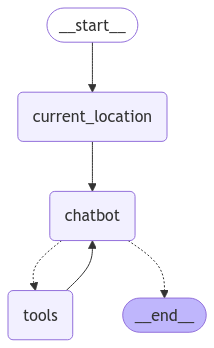

In [12]:
test.display_graph()

In [13]:
test.stream('find some vegetarian restaurants near me')

================================ Human Message =================================

find some vegetarian restaurants near me
================================ Human Message =================================

find some vegetarian restaurants near me
================================== Ai Message ==================================
Tool Calls:
  find_places_near_me (f75f444c-e46a-4ba3-a08f-919fa8efe1d2)
 Call ID: f75f444c-e46a-4ba3-a08f-919fa8efe1d2
  Args:
    query: vegetarian_restaurant
================================= Tool Message =================================
Name: find_places_near_me

I found 17 places
================================== Ai Message ==================================

I found 17 vegetarian restaurants near you.  To see the details including links, please use the `show_places_found` tool.


In [16]:
test.get_state('messages')

[HumanMessage(content='find some vegetarian restaurants near me', additional_kwargs={}, response_metadata={}, id='91d4953d-ae6d-4e16-86ff-fbb64208e07b'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'find_places_near_me', 'arguments': '{"query": "vegetarian_restaurant"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-9dc9bdec-d172-4adc-842f-4a19133a9ff8-0', tool_calls=[{'name': 'find_places_near_me', 'args': {'query': 'vegetarian_restaurant'}, 'id': 'f75f444c-e46a-4ba3-a08f-919fa8efe1d2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1790, 'output_tokens': 11, 'total_tokens': 1801, 'input_token_details': {'cache_read': 0}}),
 ToolMessage(content='I found 17 places', name='find_places_near_me', id='7a0c0c29-0e8f-42b9-b412-9767a6be01b9', tool_call_id='f75f444c-e46a-4ba3-a08f-919fa8efe1d2'),
 AIMessage(content='I found 17 vegetarian restaurants near you.  To see the